In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import gzip
import os.path
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

In [2]:
import simulate_data

M=4
PART_NUM=1000
len_mult = 100
epoch_num=20
step = (len_mult*M)/epoch_num
epoch_at=np.append(np.arange(step, len_mult*M-step+1, step), len_mult*M-1)
params={'N': len_mult*M, 
        'N_batch':1, 
        'omega_shift' : [0,3], 
        'shards': M,
        'epoch_at':epoch_at,
        'particles_per_shard':PART_NUM,
        'model':'probit_sin_wave',
        'sample_method':"importance"}

data, params = simulate_data.temp_make_data_function(params, model='probit_sin_wave', show=False)
params['shards']

4

In [3]:
data.keys()

['shard_2',
 'shard_3',
 'shard_0',
 'shard_1',
 'parallel_shards',
 'X_oos',
 'data_keys',
 'batch_number',
 'shards',
 'N',
 'epoch_data',
 'p',
 'b',
 'Y',
 'X',
 'B',
 'model',
 'b_oos']

In [4]:
#data['epoch_data']['epoch0'].keys()
#data['epoch_data']['epoch0']['B']
print(data['epoch_data']['epoch0']['shard_0'].keys())
data['epoch_data']['epoch0']['shard_0']['B']

['B', 'data_keys', 'shards', 'N', 'p', 'b', 'Y', 'X', 'model']


array([[0.00830143, 0.        ],
       [0.        , 0.00830143]])

In [2]:
#functions
from tqdm import tqdm

def easy_hist(a):
    #rng = np.random.RandomState(10)  # deterministic random data
    #a = np.hstack((rng.normal(size=1000),
    #               rng.normal(loc=5, scale=2, size=1000)
    #              )
    #             )
    plt.hist(a, num_bins = 100)#, bins='auto')  # arguments are passed to np.histogram
    #plt.title("Histogram with 'auto' bins")
    plt.show()

def load_airline_data(file_path):
    print("loading "+file_path)
    df = pd.read_csv(file_path)
    df.sort_values(by=['Year', 
                       'Month', 
                       'DayofMonth',
                       'CRSDepTime'
                      ], 
                   inplace=True
                  )
    df.reset_index(inplace = True, drop=True)
    print("load complete")
    return df

def get_airline_model_data(file_path, 
                           preds, 
                           response,
                           params,
                           output_stem_name
                          ):
    #define_response
    df = load_airline_data(file_path)
    
    df['ArrDelay_00'] = 0
    df.ArrDelay_00[df.ArrDelay>0] = 1
    df['ArrDelay_30'] = 0
    df.ArrDelay_30[df.ArrDelay>30] = 1
    df['ArrDelay_60'] = 0
    df.ArrDelay_60[df.ArrDelay>60] = 1
    df['CRSDepTime_format'] = get_format_time(df)
    index_values = df.index.values
    #pbar = tqdm(range(len(index_values)))
    #pbar.set_description("preparing data") 
    dummied_X_big = pd.get_dummies(df[preds], drop_first=True)
        
    epoch_output = {}
    for m in range(params['shards']):
        epoch_output["shard_"+str(m)]     ={}
        epoch_output["shard_"+str(m)]['X']={}
        epoch_output["shard_"+str(m)]['Y']={}
        epoch_output["shard_"+str(m)]['B']=None
        epoch_output["shard_"+str(m)]['N']=df.shape[0]
        epoch_output["shard_"+str(m)]['p']=None
        epoch_output["shard_"+str(m)]['b']=None
        epoch_output["shard_"+str(m)]['data_keys']=list()
        epoch_output["shard_"+str(m)]['shards']=params['shards']
        epoch_output["shard_"+str(m)]['model']='probit_sin_wave'
        
    dummied_X = dummied_X_big[dummied_X_big.Month == key_vals[i]]
        
    for i in range(params['shards']):#pbar:
            
        print(i, "out ot ", params['shards'])
        temp_X = dummied_X.iloc[i::params['shards'], :]#df[preds].iloc[i::params['shards'], :]
        temp_Y = df[[response]].iloc[i::params['shards'], :]
        print("data made")
        #print(temp_X.head())
        #print(temp_X.index.values)
        #temp_X = df[preds].iloc[index_values[i]]
        print("re-indexing")
        lst1 = map(str, temp_X.index.values)#temp_X.index.values#['0','4','8','12','16']
        lst2 = map(str, range(len(temp_X.index.values)))#['1','2','3','4','5']
    
        #at        = np.full(fill_value=':',shape=len(lst1),dtype=object) #optional third list
        data_keys = np.array(lst1,dtype=object)+':'+np.array(lst2,dtype=object)
        #print(data_keys)
        temp_X.set_index(data_keys, inplace=True)
        print("dictionaryizing")
        temp_X_dict = temp_X.T.to_dict('list')
        print("filling shard data")
        epoch_output["shard_"+str(i)]['X']=temp_X_dict#{}
        #epoch_output["shard_"+str(i)]['Y']={}
        epoch_output["shard_"+str(i)]['data_keys']=data_keys#list()
        epoch_output["shard_"+str(i)]['p']=dummied_X.shape[1]+1
        #print(temp_X_dict.keys())
        #return epoch_output

    return epoch_output

def break_up_by_month(df, key_vals, output_stem_name, format):
    for i in key_vals.Month.values:
        print("working key_val ", i)
        pre_pickle = df[df.Month==i]
        if format == 'pk':
            pickle.dump(pre_pickle, 
                        open('data/pre_use'+output_stem_name+str(i)+'.pk', 'wb'), 
                        protocol=2
                       )
        if format == 'bz2':
            pre_pickle.to_csv('data/pre_use'+output_stem_name+str(i)+'.csv.bz2',
                              compression='bz2'
                             )
        
def get_format_time(df):
    
    year       = df.Year.astype(str)
    month      = df.Month.astype(str).str.zfill(2)
    dayofmonth = df.DayofMonth.astype(str).str.zfill(2)
    minofday   = df.CRSDepTime.astype(str).str.zfill(4)
    
    index = minofday >= str(2400)
    minofday[index] = "2359"
    
    output = year+month+dayofmonth+minofday
    # to do: convert to python datetime
    return output

def break_up_by_dom_and_month(df, key_vals, osm, format):
    for i in key_vals.index.values:
        #print("working key_val ", i)
        pre_pickle = df.loc[(df.Month==key_vals.Month[i]) & (df.DayofMonth==key_vals.DayofMonth[i])]
        m_val=key_vals.Month[i]
        dom_val=key_vals.DayofMonth[i]
        other='mo'+str(m_val)+'dom'+str(dom_val)
        if format == 'pk':
            pickle.dump(pre_pickle, 
                        open('pre_use_ymdom/pre_use'+osm+other+'.pk', 'wb'), 
                        protocol=2
                       )
        if format == 'bz2':
            pre_pickle.to_csv('pre_use_ymdom/pre_use'+osm+other+'.csv.bz2',
                              compression='bz2'
                             )

In [6]:
Month_vals         = []
DayOfWeek_vals     = [] 
UniqueCarrier_vals = []
Origin_vals        = []
Dest_vals          = []

for yr in range(1987, 2009):
    output_stem_name=str(yr)
    print("working " + str(yr))

    df = load_airline_data('data/'+output_stem_name+'.csv.bz2')
    
    df['ArrDelay_00'] = 0
    df.ArrDelay_00[df.ArrDelay>0] = 1
    df['ArrDelay_30'] = 0
    df.ArrDelay_30[df.ArrDelay>30] = 1
    df['ArrDelay_60'] = 0
    df.ArrDelay_60[df.ArrDelay>60] = 1
    
    Month_vals         = list(set(df.Month)         | set(Month_vals))
    DayOfWeek_vals     = list(set(df.DayOfWeek)     | set(DayOfWeek_vals))
    UniqueCarrier_vals = list(set(df.UniqueCarrier) | set(UniqueCarrier_vals))
    Origin_vals        = list(set(df.Origin)        | set(Origin_vals))
    Dest_vals          = list(set(df.Dest)          | set(Dest_vals))
    
    key_vals = df[['Month', 'DayofMonth']].drop_duplicates()
    #key_vals = df[['Month']].drop_duplicates()
    key_vals.reset_index(inplace=True, drop=True)
    break_up_by_dom_and_month(df, key_vals, output_stem_name, 'bz2')
    #break_up_by_month(df, key_vals, output_stem_name, 'bz2')

working 1987
loading data/1987.csv.bz2
load complete


/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


working 1988
loading data/1988.csv.bz2
load complete
working 1989
loading data/1989.csv.bz2
load complete
working 1990
loading data/1990.csv.bz2
load complete
working 1991
loading data/1991.csv.bz2
load complete
working 1992
loading data/1992.csv.bz2
load complete
working 1993
loading data/1993.csv.bz2
load complete
working 1994
loading data/1994.csv.bz2
load complete
working 1995
loading data/1995.csv.bz2
load complete
working 1996
loading data/1996.csv.bz2
load complete
working 1997
loading data/1997.csv.bz2
load complete
working 1998
loading data/1998.csv.bz2
load complete
working 1999
loading data/1999.csv.bz2
load complete
working 2000
loading data/2000.csv.bz2
load complete
working 2001
loading data/2001.csv.bz2
load complete
working 2002
loading data/2002.csv.bz2
load complete
working 2003
loading data/2003.csv.bz2


/Users/omarchavez/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


load complete
working 2004
loading data/2004.csv.bz2
load complete
working 2005
loading data/2005.csv.bz2
load complete
working 2006
loading data/2006.csv.bz2
load complete
working 2007
loading data/2007.csv.bz2
load complete
working 2008
loading data/2008.csv.bz2
load complete


In [7]:
key_vals.Month.values

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [8]:
uMonth_vals         = np.unique(Month_vals)
uDayOfWeek_vals     = np.unique(DayOfWeek_vals)
uUniqueCarrier_vals = np.unique(UniqueCarrier_vals)
uOrigin_vals        = np.unique(Origin_vals)
uDest_vals          = np.unique(Dest_vals)
pickle.dump(uMonth_vals        , open('pdata/uMonth_vals.pk', 'wb'), protocol=2)
pickle.dump(uDayOfWeek_vals    , open('pdata/uDayOfWeek_vals.pk', 'wb'), protocol=2)
pickle.dump(uUniqueCarrier_vals, open('pdata/uUniqueCarrier_vals.pk', 'wb'), protocol=2)
pickle.dump(uOrigin_vals       , open('pdata/uOrigin_vals.pk', 'wb'), protocol=2)
pickle.dump(uDest_vals         , open('pdata/uDest_vals.pk', 'wb'), protocol=2)

In [9]:
#"Month" + map(str, Month_vals)
Month_names         = ["Month_"         + s for s in map(str, uMonth_vals)]#.sort()
DayOfWeek_names     = ["DayOfWeek_"     + s for s in map(str, uDayOfWeek_vals)]#.sort()
UniqueCarrier_names = ["UniqueCarrier_" + s for s in uUniqueCarrier_vals]
Origin_names        = ["Origin_"        + s for s in uOrigin_vals]#.sort()
Dest_names          = ["Dest_"          + s for s in uDest_vals]#.sort()

In [10]:
df.keys()

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime',
       u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance',
       u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'ArrDelay_00', u'ArrDelay_30', u'ArrDelay_60'],
      dtype='object')

In [11]:
#print(Month_names        )
#print(DayOfWeek_names    )
#print(UniqueCarrier_names)
#print(Origin_names       )
#print(Dest_names         )
pickle.dump(Month_names        , open('pdata/Month_names.pk', 'wb'), protocol=2)
pickle.dump(DayOfWeek_names    , open('pdata/DayOfWeek_names.pk', 'wb'), protocol=2)
pickle.dump(UniqueCarrier_names, open('pdata/UniqueCarrier_names.pk', 'wb'), protocol=2)
pickle.dump(Origin_names       , open('pdata/Origin_names.pk', 'wb'), protocol=2)
pickle.dump(Dest_names         , open('pdata/Dest_names.pk', 'wb'), protocol=2)

In [3]:
Month_names         = pickle.load(open('pdata/Month_names.pk', 'rb'))
DayOfWeek_names     = pickle.load(open('pdata/DayOfWeek_names.pk', 'rb'))
UniqueCarrier_names = pickle.load(open('pdata/UniqueCarrier_names.pk', 'rb'))
Origin_names        = pickle.load(open('pdata/Origin_names.pk', 'rb'))
Dest_names          = pickle.load(open('pdata/Dest_names.pk', 'rb'))

In [35]:
colnames = Month_names + DayOfWeek_names#[1:]
colnames = colnames + UniqueCarrier_names#[1:] 
colnames = colnames + Origin_names#[1:] 
colnames = colnames + Dest_names#[1:]
colnames = colnames + [
    'CRSDepTime', 
    'CRSArrTime', 
    'FormatTime',
    'ArrDelay_00',
    'ArrDelay_30',
    'ArrDelay_60',
    'ArrDelay',
    'DepDelay',
    'DepTime',
    'CRSElapsedTime',
    'ActualElapsedTime',	
    'Distance'
]

compact_cols=['Month',
              'DayOfWeek',
              'UniqueCarrier',
              'Origin',
              'Dest',
              'CRSDepTime', 
              'CRSArrTime',
              'ArrDelay_00',
              'ArrDelay_30',
              'ArrDelay_60',
              'ArrDelay',
              'DepDelay',
              'DepTime',
              'CRSElapsedTime',
              'ActualElapsedTime',
              'Distance'
]

In [36]:
##save X (design matrix) data by month
#X_col_size = len(colnames)    
#
#for yr in range(1987, 2009):
#    print("working ", yr)
#    for mo in range(1,13):
#        ext=str(yr)+str(mo)
#        fname = 'data/pre_use'+ext+'.csv.bz2'
#        if os.path.isfile(fname):
#            #print("working " + ext)
#            air_month_file = pd.read_csv(fname)#pickle.load(open(fname, "rb" ))
#            row_num = air_month_file.shape[0]
#            raw_X = pd.DataFrame(np.zeros((row_num, X_col_size)),
#                             columns=colnames
#                            )
#            temp=pd.to_datetime(get_format_time(air_month_file))
#            raw_X[['FormatTime']]=temp.reset_index(drop=True)
#        
#            temp_pre_dummie = air_month_file[compact_cols]
#            temp_pre_dummie['Month']     = temp_pre_dummie['Month'].astype('category')
#            temp_pre_dummie['DayOfWeek'] = temp_pre_dummie['DayOfWeek'].astype('category')
#            temp_pre_dummie.reset_index(drop=True, inplace=True)
#            temp_dummies = pd.get_dummies(temp_pre_dummie, 
#                                      drop_first=False
#                                     )
#            temp_cnames = temp_dummies.columns.values
#            
#            raw_X[temp_cnames] = temp_dummies[temp_cnames]
#
#            Xname = 'Xdata/X'+ext+'.csv.bz2'
#
#            raw_X.to_csv(Xname, compression='bz2')
#            
#            if raw_X.isnull().values.any():
#                break
#        else:
#            continue
#        if raw_X.isnull().values.any():
#            break
#    else: 
#        continue
#    if raw_X.isnull().values.any():
#        break
##df.head()

In [ ]:
#save X (design matrix) data by day

X_col_size = len(colnames)    

for yr in range(1987, 2009):
    print("working ", yr)
    for mo in range(1,13):
        for dom in range(1,32):
            ext=str(yr)+'mo'+str(mo)+'dom'+str(dom)
            fname = 'pre_use_ymdom/pre_use'+ext+'.csv.bz2'
            if os.path.isfile(fname):
                #print("working " + ext)
                air_month_file = pd.read_csv(fname)#pickle.load(open(fname, "rb" ))
                row_num = air_month_file.shape[0]
                raw_X = pd.DataFrame(np.zeros((row_num, X_col_size)),
                                 columns=colnames
                                )
                temp=pd.to_datetime(get_format_time(air_month_file))
                raw_X[['FormatTime']]=temp.reset_index(drop=True)
            
                temp_pre_dummie = air_month_file[compact_cols]
                temp_pre_dummie['Month']     = temp_pre_dummie['Month'].astype('category')
                temp_pre_dummie['DayOfWeek'] = temp_pre_dummie['DayOfWeek'].astype('category')
                temp_pre_dummie.reset_index(drop=True, inplace=True)
                temp_dummies = pd.get_dummies(temp_pre_dummie, 
                                          drop_first=False
                                         )
                temp_cnames = temp_dummies.columns.values
            
                #print(set(temp_cnames).difference(set(colnames)))
                #if False:
                raw_X[temp_cnames] = temp_dummies[temp_cnames]

                Xname = 'Xdata_dom/X'+ext+'.csv.bz2'
                raw_X = raw_X.dropna()
                raw_X.T.to_csv(Xname, compression='bz2')
                #last=raw_X
                if raw_X.isnull().values.any():
                    break
            else:
                continue
            if raw_X.isnull().values.any():
                break
        else:
            continue
        if raw_X.isnull().values.any():
            break
    else: 
        continue
    if raw_X.isnull().values.any():
        break
#df.head()

('working ', 1987)


/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/omarchavez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('working ', 1988)
('working ', 1989)
('working ', 1990)
('working ', 1991)
('working ', 1992)
('working ', 1993)
('working ', 1994)
('working ', 1995)
('working ', 1996)
('working ', 1997)
('working ', 1998)
('working ', 1999)
('working ', 2000)
('working ', 2001)


In [41]:
raw_X.isnull().values.any()
raw_X.shape
raw_X.head()
for cn in raw_X.columns:
    if raw_X[cn].isnull().values.any():
        print(cn)

Month_10
DayOfWeek_4
UniqueCarrier_AA
UniqueCarrier_AS
UniqueCarrier_CO
UniqueCarrier_DL
UniqueCarrier_EA
UniqueCarrier_HP
UniqueCarrier_NW
UniqueCarrier_PA (1)
UniqueCarrier_PI
UniqueCarrier_PS
UniqueCarrier_TW
UniqueCarrier_UA
UniqueCarrier_US
UniqueCarrier_WN
Origin_ABE
Origin_ABQ
Origin_ACV
Origin_AGS
Origin_ALB
Origin_ALO
Origin_AMA
Origin_ANC
Origin_APF
Origin_ATL
Origin_ATW
Origin_AUS
Origin_AVL
Origin_AVP
Origin_AZO
Origin_BDL
Origin_BET
Origin_BFL
Origin_BGM
Origin_BGR
Origin_BHM
Origin_BIL
Origin_BIS
Origin_BLI
Origin_BNA
Origin_BOI
Origin_BOS
Origin_BTM
Origin_BTR
Origin_BTV
Origin_BUF
Origin_BUR
Origin_BWI
Origin_BZN
Origin_CAE
Origin_CAK
Origin_CCR
Origin_CDV
Origin_CHA
Origin_CHO
Origin_CHS
Origin_CID
Origin_CLE
Origin_CLT
Origin_CMH
Origin_CMI
Origin_COS
Origin_CPR
Origin_CRP
Origin_CRW
Origin_CSG
Origin_CVG
Origin_CWA
Origin_DAB
Origin_DAL
Origin_DAY
Origin_DCA
Origin_DEN
Origin_DFW
Origin_DLH
Origin_DRO
Origin_DSM
Origin_DTW
Origin_EAU
Origin_ELM
Origin_ELP
Origin_ERI


In [47]:
raw_X[cn].isnull().values.any()

True

In [42]:
pd.set_option('display.max_columns', 1000)


type(raw_X)

pandas.core.frame.DataFrame

In [49]:
raw_X[['DepTime','CRSArrTime']]
raw_X.iloc[86]

Month_1                                   0
Month_2                                   0
Month_3                                   0
Month_4                                   0
Month_5                                   0
Month_6                                   0
Month_7                                   0
Month_8                                   0
Month_9                                   0
Month_10                                  1
Month_11                                  0
Month_12                                  0
DayOfWeek_1                               0
DayOfWeek_2                               0
DayOfWeek_3                               0
DayOfWeek_4                               1
DayOfWeek_5                               0
DayOfWeek_6                               0
DayOfWeek_7                               0
UniqueCarrier_9E                          0
UniqueCarrier_AA                          0
UniqueCarrier_AQ                          0
UniqueCarrier_AS                

In [38]:
last.head()

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,UniqueCarrier_EA,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_HP,UniqueCarrier_ML (1),UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_PA (1),UniqueCarrier_PI,UniqueCarrier_PS,UniqueCarrier_TW,UniqueCarrier_TZ,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,Origin_ABE,Origin_ABI,Origin_ABQ,Origin_ABY,Origin_ACK,Origin_ACT,Origin_ACV,Origin_ACY,Origin_ADK,Origin_ADQ,Origin_AEX,Origin_AGS,Origin_AKN,Origin_ALB,Origin_ALO,Origin_AMA,Origin_ANC,Origin_ANI,Origin_APF,Origin_ASE,Origin_ATL,Origin_ATW,Origin_AUS,Origin_AVL,Origin_AVP,Origin_AZO,Origin_BDL,Origin_BET,Origin_BFF,Origin_BFI,Origin_BFL,Origin_BGM,Origin_BGR,Origin_BHM,Origin_BIL,Origin_BIS,Origin_BJI,Origin_BLI,Origin_BMI,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BPT,Origin_BQK,Origin_BQN,Origin_BRO,Origin_BRW,Origin_BTM,Origin_BTR,Origin_BTV,Origin_BUF,Origin_BUR,Origin_BWI,Origin_BZN,Origin_CAE,Origin_CAK,Origin_CCR,Origin_CDC,Origin_CDV,Origin_CEC,Origin_CHA,Origin_CHO,Origin_CHS,Origin_CIC,Origin_CID,Origin_CKB,Origin_CLD,Origin_CLE,Origin_CLL,Origin_CLT,Origin_CMH,Origin_CMI,Origin_CMX,Origin_COD,Origin_COS,Origin_CPR,Origin_CRP,Origin_CRW,Origin_CSG,Origin_CVG,Origin_CWA,Origin_CYS,Origin_DAB,Origin_DAL,Origin_DAY,Origin_DBQ,Origin_DCA,Origin_DEN,Origin_DET,Origin_DFW,Origin_DHN,Origin_DLG,Origin_DLH,Origin_DRO,Origin_DSM,Origin_DTW,Origin_DUT,Origin_EAU,Origin_EFD,Origin_EGE,Origin_EKO,Origin_ELM,Origin_ELP,Origin_ERI,Origin_EUG,Origin_EVV,Origin_EWN,Origin_EWR,Origin_EYW,Origin_FAI,Origin_FAR,Origin_FAT,Origin_FAY,Origin_FCA,Origin_FLG,Origin_FLL,Origin_FLO,Origin_FMN,Origin_FNT,Origin_FOE,Origin_FSD,Origin_FSM,Origin_FWA,Origin_GCC,Origin_GCN,Origin_GEG,Origin_GFK,Origin_GGG,Origin_GJT,Origin_GLH,Origin_GNV,Origin_GPT,Origin_GRB,Origin_GRK,Origin_GRR,Origin_GSO,Origin_GSP,Origin_GST,Origin_GTF,Origin_GTR,Origin_GUC,Origin_GUM,Origin_HDN,Origin_HHH,Origin_HKY,Origin_HLN,Origin_HNL,Origin_HOU,Origin_HPN,Origin_HRL,Origin_HSV,Origin_HTS,Origin_HVN,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IDA,Origin_ILE,Origin_ILG,Origin_ILM,Origin_IND,Origin_INL,Origin_IPL,Origin_ISO,Origin_ISP,Origin_ITH,Origin_ITO,Origin_IYK,Origin_JAC,Origin_JAN,Origin_JAX,Origin_JFK,Origin_JNU,Origin_KOA,Origin_KSM,Origin_KTN,Origin_LAN,Origin_LAS,Origin_LAW,Origin_LAX,Origin_LBB,Origin_LCH,Origin_LEX,Origin_LFT,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_LMT,Origin_LNK,Origin_LNY,Origin_LRD,Origin_LSE,Origin_LWB,Origin_LWS,Origin_LYH,Origin_MAF,Origin_MAZ,Origin_MBS,Origin_MCI,Origin_MCN,Origin_MCO,...,Dest_EUG,Dest_EVV,Dest_EWN,Dest_EWR,Dest_EYW,Dest_FAI,Dest_FAR,Dest_FAT,Dest_FAY,Dest_FCA,Dest_FLG,Dest_FLL,Dest_FLO,Dest_FMN,Dest_FNT,Dest_FOE,Dest_FSD,Dest_FSM,Dest_FWA,Dest_GCC,Dest_GCN,Dest_GEG,Dest_GFK,Dest_GGG,Dest_GJT,Dest_GLH,Dest_GNV,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GST,Dest_GTF,Dest_GTR,Dest_GUC,Dest_GUM,Dest_HDN,Dest_HHH,Dest_HKY,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_HTS,Dest_HVN,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILE,Dest_ILG,Dest_ILM,Dest_IND,Dest_INL,Dest_IPL,Dest_ISO,Dest_ISP,Dest_ITH,Dest_ITO,Dest_IYK,Dest_JAC,Dest_JAN,Dest_JAX,Dest_JFK,Dest_JNU,Dest_KOA,Dest_KSM,Dest_KTN,Dest_LAN,Dest_LAR,Dest_LAS,Dest_LAW,Dest_LAX,Dest_LBB,Dest_LBF,Dest_LCH,Dest_LEX,Dest_LFT,Dest_LGA,Dest_LGB,Dest_LIH,Dest_LIT,Dest_LMT,Dest_LNK,Dest_LNY,Dest_LRD,Dest_LSE,Dest_LWB,Dest_LWS,Dest_LYH,Dest_MAF,Dest_MAZ,Dest_MBS,Dest_MCI,Dest_MCN,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEI,Dest_MEM,Dest_MFE,Dest_MFR,Dest_MGM,Dest_MHT,Dest_MIA,Dest_MIB,Dest_MKC,Dest_MKE,Dest_MKG,Dest_MKK,Dest_MLB,Dest_MLI,Dest_MLU,Dest_MOB,Dest_MOD,Dest_MOT,Dest_MQT,

(-50, 150)

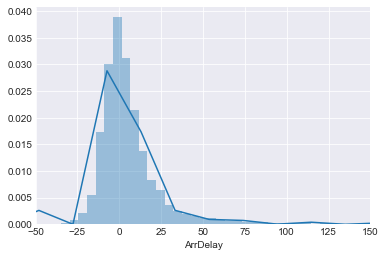

In [71]:
d = airdat.ArrDelay[~np.isnan(airdat.ArrDelay)]
sns.set_style('darkgrid')
sns.distplot(d, bins=500)
#sns.plt.ylim(0, 20)
plt.xlim(-50, 150)

In [17]:
import pickle
import pandas as pd

pd.set_option('display.max_columns', 1000)
thing = pickle.load(open('Xdata/X1990mo9dom9.pk', 'rb'))

0